In [1]:
import pandas as pd
pd.options.display.float_format = '{:,.2f}'.format # use 2 decimals, not scientific notation

In [ ]:
import s3fs
s3 = s3fs.S3FileSystem(anon=True)
s3.ls('twde-datalab/raw')

#may require `mkdir data/`
s3.get('twde-datalab/raw/quito_stores_sample2016-2017.csv', 
       '../data/quito_stores_sample2016-2017.csv')

In [2]:
data = pd.read_csv('../data/quito_stores_sample2016-2017.csv')

/home/lukas/.local/share/virtualenvs/continuous-intelligence-workshop-TFHS9Pyf/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


#### Starting with `.describe()` is never a bad place to start data exploration 

In [3]:
data.unit_sales.describe()

count   2,263,568.00
mean           14.08
std            31.09
min          -200.00
25%             3.00
50%             7.00
75%            15.00
max         4,930.00
Name: unit_sales, dtype: float64

### I have questions about those *negative sales*. How do you negative sell something?
That's got my gears turning. Here are some of my new questions about the data:
- Question: What does a negative sale mean?
- Question: How often are sales negative?
- Question: How many times are sales above 5,000?
- Question: How do the unit_sales numbers vary with the `date` column?


#### A good way to answer these questions is with some visualizations.

It might be difficult to get an intuitive feel of the data by knowing the exact answer to many of those questions. What we actually want to learn is the personality of the data. We want to know what it looks like in a glance.

### Let's import the python libraries that do the heavy lifting of data visualization

In [4]:
%matplotlib inline
import random
import matplotlib.pyplot as plt
import seaborn as sns

and then let's look at a box plot of unit sales. A box plot conveys the mean and the middle 50% of the data.

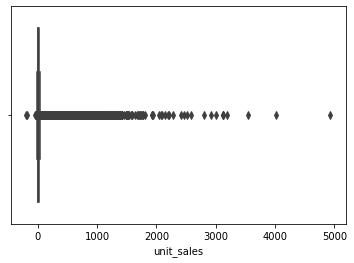

In [5]:
sns.boxplot(data.unit_sales)

**This box plot is awful.** We can't even recognize the inter-quartile-range. 

Let's make a decision: **Ignore "very large" values** (perhaps to be explored later)

In [6]:
outliers = data[data.unit_sales > 1000]

In [7]:
majority_of_data = data[data.unit_sales <= 1000]

and once again look at the boxplot of the non-outlier (for lack of a better term) data

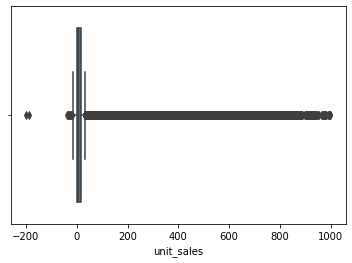

In [8]:
sns.boxplot(majority_of_data.unit_sales)

I'm surprised. This plot isn't any better than the first one. Let's try a different visualization... Maybe kernel density estimation plot. 

This shows us the probability of a data point being a certain value.

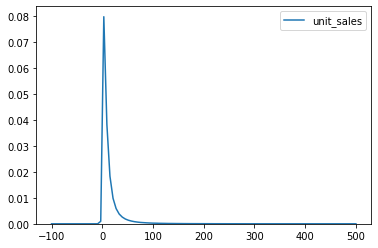

In [9]:
sns.kdeplot(majority_of_data.unit_sales, clip=[-100,500])

We can see that the likelihood of getting a certain unit_sales value tapers off dramatically and has almost vanished by a unit_sales of 100.

I'd also like to know how do sales change over time. 
**Is there a weekly cycle? A monthly cycle?**
Let's look at that with a line graph.

#### First, we convert the date column into a datetime object, and set it as the index
Then we find the weekly average of the data and plot it

In [10]:
data.index = pd.to_datetime(data.date)

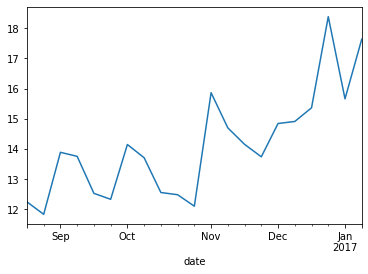

In [14]:
data.unit_sales.resample('W').mean().plot(x='index',y='unit_sales')

Here we can see something that seems interesting around December-January. We also see what appears to be a couple sales cycles throughout the year. 

**What do you think causes the huge drop off in August-September?**

I'm curious to see if returns happen more frequently after Christmas, so I'm going to repeat the above plot, but only focusing on returns.

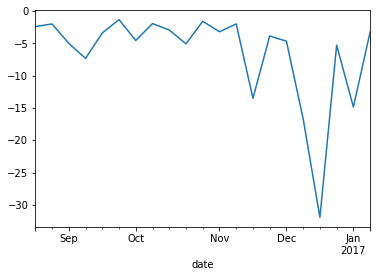

In [15]:
data[data.unit_sales < 0].unit_sales.resample('W').mean().plot(x='index',y='unit_sales')

This graph is surprising to me. Is it surprising to you? I still strongly suspect that returns happen at a statistically significantly different rate after Christmas, given that purchases spike around Dec-Jan anyway.  My next thought is about those outliers. Maybe `mean` isn't the right measurement to use, since means can be skewed by outliers. 

Let's see the same graph as above, only this time using `median` as the measurement. 

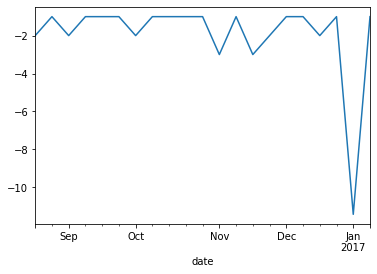

In [16]:
data[data.unit_sales < 0].unit_sales.resample('W').median().plot(x='index',y='unit_sales')

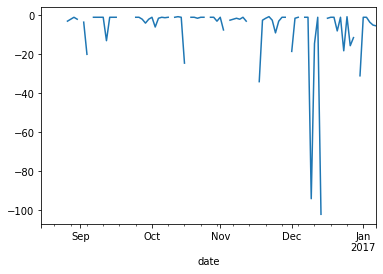

In [35]:
data[data.unit_sales < 0].unit_sales.resample('B').median().plot(x='index',y='unit_sales')

In [41]:
data[data.unit_sales < 0].groupby(data[data.unit_sales < 0].index.weekday_name)['unit_sales'].mean()

date
Friday      -14.00
Monday       -4.13
Saturday     -5.60
Sunday       -2.25
Thursday     -4.21
Tuesday      -3.04
Wednesday    -9.86
Name: unit_sales, dtype: float64

In [53]:
data[data.unit_sales > 0].groupby(data[data.unit_sales > 0].index.weekday_name)['unit_sales'].sum()

date
Friday      4,460,195.87
Monday      4,280,489.77
Saturday    5,432,079.83
Sunday      5,924,205.07
Thursday    3,538,246.72
Tuesday     3,829,697.83
Wednesday   4,396,556.12
Name: unit_sales, dtype: float64

In [39]:
data.index.weekday_name

Index(['Tuesday', 'Tuesday', 'Tuesday', 'Tuesday', 'Tuesday', 'Tuesday',
       'Tuesday', 'Tuesday', 'Tuesday', 'Tuesday',
       ...
        'Friday',  'Friday',  'Friday',  'Friday',  'Friday',  'Friday',
        'Friday',  'Friday',  'Friday',       nan],
      dtype='object', name='date', length=2263569)

There we go. Look at that. When we use a statistic that is robust to outliers, we can see that return behavior is very different around Christmas.

What can we do with this knowledge? If we're to predict sales and returns for the end of December and beginning of January, our model should incorporate the effect of Christmas on sales. Perhaps it'd be useful to add columns called, `is_two_weeks_before_christmas` and `is_two_weeks_after_christmas`. 

In [ ]:
# import os
# import urllib.request
# import argparse

# def load_data(path, key):
#     gcsBucket = "continuous-intelligence"

#     if not os.path.exists(path):
#         os.makedirs(path)

#     if not os.path.exists(os.path.join(path, key)):
#         url = "https://storage.googleapis.com/%s/%s" % (gcsBucket, key)
#         urllib.request.urlretrieve(url, os.path.join(path, key))

# load_data(path='data/raw', key='store47-2016.csv')

